<br>
<br>
<font size=10><b>Анализ исходящих вызовов абонента</b></font>
<br>
<br>
<br>
<br>
<br>
Абонент хочет оптимизировать свои затраты на связь, сменив текущий тарифный план. <br><b>Три оператора сотовой связи</b> прислали свои предложения. <br><br>
Необходимо исследовать характер исходящих звонков абонента и <b>предложить оптимальный тариф</b>, обосновав свои рекомендации аналитическими расчетами.

## Эпизод 1 
---
### Import and Data load

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [122]:
data = pd.read_excel('data/abonent.xlsx')

In [123]:
data

,Дата звонка,Длительность разговора,Оператор связи вызываемого абонента
0,15.12.2010 10:50:54,00:01:49,билайн
1,15.12.2010 11:50:42,00:00:57,билайн
2,30.11.2010 16:39:34,00:00:55,билайн
3,30.11.2010 16:39:34,00:00:55,билайн
4,01.12.2010 09:49:09,00:06:47,билайн
...,...,...,...
1225,16.12.2010 15:20:12,00:00:26,яртелеком
1226,16.12.2010 16:30:41,00:01:35,яртелеком
1227,14.12.2010 18:11:18,00:00:08,яртелеком
1228,14.12.2010 18:11:56,00:00:45,яртелеком


## Эпизод 2 
---
### Разведовочный анализ

Проверим данные на наличие пропусков

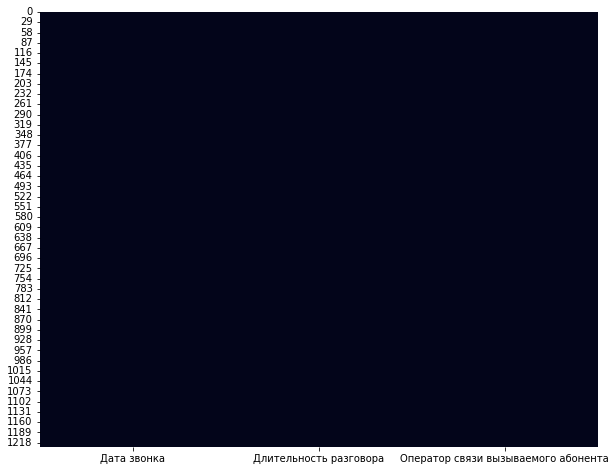


 Количество пропусков в каждом столбце: 


Дата звонка                            0
Длительность разговора                 0
Оператор связи вызываемого абонента    0
dtype: int64

In [124]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.isnull(), cbar=False)
plt.show()

print('\n Количество пропусков в каждом столбце: ')
data.isnull().sum()

Heatmap и кол-во пропусков говорят о том, что пропусков нет

Пройдемся по значениям категориальных признаков

In [125]:
categorical_columns = [col for col in data
                       if data[col].dtypes == 'object']
for col in categorical_columns:
    print(f'{col} DESCRIPTION:')
    print(data[col].value_counts())
    print('\n')

Дата звонка DESCRIPTION:
30.11.2010 18:07:58    2
30.11.2010 09:15:21    2
20.11.2010 15:11:20    2
30.09.2010 10:00:45    2
30.08.2010 09:30:16    2
                      ..
09.11.2010 11:49:04    1
09.11.2010 11:52:57    1
21.10.2010 09:36:34    1
01.12.2010 11:06:49    1
27.09.2010 14:13:48    1
Name: Дата звонка, Length: 1161, dtype: int64


Длительность разговора DESCRIPTION:
00:00:11    24
00:00:13    22
00:00:35    21
00:00:20    20
00:00:06    19
            ..
00:02:56     1
00:03:21     1
00:02:29     1
00:03:22     1
00:02:45     1
Name: Длительность разговора, Length: 291, dtype: int64


Оператор связи вызываемого абонента DESCRIPTION:
городской         447
билайн            407
мтс               258
смартс             58
мегафон            46
яртелеком          11
теле 2              2
уралсвязьинфом      1
Name: Оператор связи вызываемого абонента, dtype: int64




Уже по этим данным можно сказать, что абонент склонен к </b>коротким звонкам на городские номера</b>

In [126]:
from datetime import time

def sum_time(time1: datetime.datetime, time2: datetime.datetime):
    """ Функция суммирует время """
    th1, tm1, ts1 = time1.hour, time1.minute, time1.second
    th2, tm2, ts2 = time2.hour, time2.minute, time2.second

    th3, tm3, ts3 = th1 + th2, tm1 + tm2, ts1 + ts2
    tm3, ts3 = tm3 + ts3 // 60, ts3 % 60
    th3, tm3 = th3 + tm3 // 60, tm3 % 60

    # На всякий случай. Вдруг больше дня получится =)
    th3 = th3 % 24

    return time(th3, tm3, ts3)

Из колонки "Дата звонка" уберем время и оставим только дату

In [128]:
data['Дата звонка'] = [date.split()[0] for date in data['Дата звонка']]
data

,Дата звонка,Длительность разговора,Оператор связи вызываемого абонента
0,15.12.2010,00:01:49,билайн
1,15.12.2010,00:00:57,билайн
2,30.11.2010,00:00:55,билайн
3,30.11.2010,00:00:55,билайн
4,01.12.2010,00:06:47,билайн
...,...,...,...
1225,16.12.2010,00:00:26,яртелеком
1226,16.12.2010,00:01:35,яртелеком
1227,14.12.2010,00:00:08,яртелеком
1228,14.12.2010,00:00:45,яртелеком


Создадим список и заполним его всей информацией о звонке в определенный день

In [113]:
time_list = [] 
for date_time in np.unique(data['Дата звонка']): # перебор всех возможных дат
    one_day_data = data[data['Дата звонка'] == date_time]['Длительность разговора'] # рассматриваем определенный день
    # счетчики: 
    less_minute_calls = 0 # меньше минуты
    total_calls = 0 # всего звонков
    from_2_to_9 = 0 # со второй по 9 минуты
    from_10 = 0 # с 10 минуты
    from_0_to_5 = 0 # до 5 минуты
    from_30 = 0 # с 31 минуты
    from_6_to_30 = 0 # от 6 до 30 минуты
    total_time_calls = datetime.datetime.strptime('00.00.00', '%H.%M.%S') # сумма времени всех звонков
    for speak_time in one_day_data:
        speak_time = datetime.datetime.strptime(speak_time.replace(':', '.'), '%H.%M.%S')
        total_time_calls = sum_time(total_time_calls, speak_time) 
        total_calls += 1
        if speak_time <= datetime.datetime.strptime('00.01.00', '%H.%M.%S'):
            less_minute_calls += 1
        if datetime.datetime.strptime('00.01.00', '%H.%M.%S') < speak_time <= datetime.datetime.strptime('00.09.00', '%H.%M.%S'):
            from_2_to_9 += 1
        if speak_time > datetime.datetime.strptime('00.09.00', '%H.%M.%S'):
            from_10 += 1
        if datetime.datetime.strptime('00.00.00', '%H.%M.%S') < speak_time <= datetime.datetime.strptime('00.05.00', '%H.%M.%S'):
            from_0_to_5 += 1
        if speak_time > datetime.datetime.strptime('00.30.00', '%H.%M.%S'):
            from_30 += 1
        if datetime.datetime.strptime('00.05.00', '%H.%M.%S') < speak_time <= datetime.datetime.strptime('00.30.00', '%H.%M.%S'):
            from_6_to_30 += 1
    time_list.append({date_time: {
        'less minute': less_minute_calls, 
        'total calls': total_calls, 
        'total_time_call': total_time_calls,
        'from 2 to 9': from_2_to_9,
        'from 10': from_10,
        'from_0_to_5 + from_30': from_0_to_5 + from_30,
        'from 6 to 30': from_6_to_30}}) 

In [114]:
time_list

[{'01.07.2010': {'less minute': 3,
   'total calls': 4,
   'total_time_call': datetime.time(0, 2, 58),
   'from 2 to 9': 1,
   'from 10': 0,
   'from_0_to_5 + from_30': 4,
   'from 6 to 30': 0}},
 {'01.09.2010': {'less minute': 6,
   'total calls': 10,
   'total_time_call': datetime.time(0, 10, 22),
   'from 2 to 9': 4,
   'from 10': 0,
   'from_0_to_5 + from_30': 10,
   'from 6 to 30': 0}},
 {'01.10.2010': {'less minute': 4,
   'total calls': 11,
   'total_time_call': datetime.time(0, 19, 8),
   'from 2 to 9': 7,
   'from 10': 0,
   'from_0_to_5 + from_30': 10,
   'from 6 to 30': 1}},
 {'01.11.2010': {'less minute': 12,
   'total calls': 16,
   'total_time_call': datetime.time(0, 17, 30),
   'from 2 to 9': 4,
   'from 10': 0,
   'from_0_to_5 + from_30': 15,
   'from 6 to 30': 1}},
 {'01.12.2010': {'less minute': 12,
   'total calls': 22,
   'total_time_call': datetime.time(0, 38, 3),
   'from 2 to 9': 10,
   'from 10': 0,
   'from_0_to_5 + from_30': 20,
   'from 6 to 30': 2}},
 {'02.0

In [115]:
def count_total_calls(time_list: list[dict], key: str) -> int:
    """ Функция считает сколько всего было звонков в предельных условиях
        Например, сколько было звонков с 1 минуты по 5 минуту
        time_list: список со словорями, в которых записаны данные о каждом дне
        key: ключ, по которому достаются нужные данные 
        return: сколько за 6 месяцев было звонков по предельному условию"""
    total = 0
    for i in range(len(time_list)):
        for data, time in time_list[i].items():
            total += time[key]
    return total

In [118]:
total_calls = count_total_calls(time_list=time_list, key= 'total calls')
mean_calls_day = total_calls / len(time_list)

less_minute_call_total = count_total_calls(time_list=time_list, key= 'less minute')      
mean_less_minute_call_total = less_minute_call_total / len(time_list)

total_from_2_to_9 = count_total_calls(time_list=time_list, key= 'from 2 to 9')
        
total_from_10 = count_total_calls(time_list=time_list, key= 'from 10')

total_from_0_to_5_plus_from_30 = count_total_calls(time_list=time_list, key= 'from_0_to_5 + from_30')

total_from_6_to_30 = count_total_calls(time_list=time_list, key= 'from 6 to 30')

print(f'В среднем абонент делает {int(mean_calls_day)} звонков в день, {int(mean_less_minute_call_day)} из них длятся меньше минуты')
print('='*20)
print(f'Анализ за 6 месяцев: ')
print(f'Всего звонков: {total_calls}')
print(f'Звонки, которые длились:')
print(f'\t - Меньше 1 минуты: {less_minute_call_total}')
print(f'\t - От 2-ой до 9-ой: {total_from_2_to_9}')
print(f'\t - С 10-ой: {total_from_10}')
print(f'\t - До 5 минут в день включительно, с 31 минуты в день: {total_from_0_to_5_plus_from_30}')
print(f'\t - c 6 по 30 минуты включительно: {total_from_6_to_30}')

В среднем абонент делает 9 звонков в день, 5 из них длятся меньше минуты
Анализ за 6 месяцев: 
Всего звонков: 1230
Звонки, которые длились:
	 - Меньше 1 минуты: 728
	 - От 2-ой до 9-ой: 470
	 - С 10-ой: 32
	 - До 5 минут в день включительно, с 31 минуты в день: 1144
	 - c 6 по 30 минуты включительно: 86


<br>
<br>
Если бы абонент пользовался первым тарифом от <b>Билайн "Монстр общения"</b> за 6 месяцев он бы потратил: <b>1359₽</b>, то есть это выгоднее <b>тарифа "Больше слов"</b>,<br>
где ему придется только за месяц платить <b>555₽</b>. Также уже явно проигрывает тариф "Хочу сказать", так как он требует 3,95₽ до пяти минут разговора, у нас же абонент<br>
произвел звонков меньше 1 минуты 728, то есть заплатил бы он <b>2875₽</b<, это не считая от 2-ой до 5-ой. <br><br><br>

Используя тариф <b>Мегафон "33 копейки"</b>, абонент заплатил бы <b>893,66₽.</b><br><br>

Используя тариф <b>МТС "Много звонков"</b>, абонент заплатил бы<b>1033,9₽</b><br><br>
    
<font size=5> <b>Вывод:</b></font><br>
- Анализ исходящих вызовов абонента показал, что самым подходящим тарифом является <b>Мегафон "33 копейки"</b>. <br>
- Он показал наименьшие затраты и плюс включает в себя звонки абонентам других операторов, что тоже важный показатель для абонента.